# Load libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# For prints I am using logging because it is a more general framework
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


# Define custom functions

In [2]:
  
def extract_expiring_minutes(x):
    
    """
    This function takes as input a string formatted as '<number> <metric> <xx>' and returns the minutes before expiring.
    When x = 'Listing expired' we set it to 0.
    When x is null it returns -999. General errors are handled through a -99. 
    
    Parameters
    ----------
    x : string
    
    Returns
    ----------
    float 
    """
    
    # If input is null, return -999
    if pd.isnull(x):
        return float(-999)
    
    # Make string to lower to make it safer
    x = x.lower()
    
    if(x=='listing expired'):
        return float(0)
    else:
        try:
            split_string = x.split(" ")
            split_number = split_string[0]
            split_metric = split_string[1]
            
            if(split_metric == 'minutes'):
                return float(split_number)
            elif(split_metric == 'hours'):
                return float(split_number)*60
            elif(split_metric == 'days'):
                return float(split_number)*60*24
            else:
                return float(-999)
        except:
            return float(-99)
        
def run_unit_tests_extract_expiring_minutes():
    
    """
    This function runs unit tests for the function extract_expiring_minutes(x).
    """
    
    logging.info(' ')
    logging.info('########################')
    logging.info('Start unit tests for function extract_expiring_minutes')
    
    # Define set of strings to be tested
    list_input_unit_tests = [
                            '3 hours left', '3 minutes left', '3 days left', 'listing expired'
                            ,'3 HOuRS LEFT', '3 MINuTES LEFT', '3 Days left', 'Listing expired'
                            , '', ' ', 'this should return a -999', 'thisshouldreturna-99'
                            ]
    for x in list_input_unit_tests:
        logging.info(f'Input: {x} -> output: {extract_expiring_minutes(x)}')
        
    logging.info('########################')
    logging.info('End unit tests for function extract_expiring_minutes')
    logging.info(' ')
    
    return
        
def custom_1hot_encoder(df, col, threshold_value_counts=0):
    
    """
    This function performs 1-hot encoding of a categorical variable; sparse categorical variables can be controlled by the parameters
    threshold_value_counts, which creates an encoded column only if the number of observation for a sparse level is greater than threshold_value_counts.
    
    Parameters
    ----------
    df : pandas Dataframe
    
    col : string
         Column on which we want to perform 1-hot encoding
         
    threshold_value_counts : float, default to 0.
                             Parameter which handles sparsity. Must be positive. 
                             If the number of observation of a level is < threshold_value_counts, then we merge the level into a "OTHER" level.
    
    Returns
    ----------
    pandas frame with the encoded columns 
    """
    
    # Get the column distribution
    df_value_counts = df[col].value_counts().reset_index()
    
    # Filter levels that have a frequency greater than threshold_value_counts
    df_value_counts = df_value_counts[df_value_counts[col] >= threshold_value_counts]
    
    # Extract column levels
    levels = df_value_counts['index'].unique().tolist()
    
    list_encoded = []
    for level in levels:
        df[f'encoded_{col}_{level}'] = df[col].map(lambda x: 1 if x==level else 0)
        list_encoded.append(f'encoded_{col}_{level}')
        
    df[f'encoded_{col}_other'] = 1- df[list_encoded].sum(axis = 1)
    
    return df

def get_list_constant_numerical_features(df, list_features):
    
    """
    This function returns a list of constant features of a dataframe.
    
    Parameters
    ----------
    df : pandas Dataframe
    
    list_features : list
                    List of columns to be analyzed
    
    Returns
    ----------
    list of constant columns 
    """
    
    list_constant_features = []
    for col in list_features:
        if (df[col].value_counts().shape[0] == 1):
            list_constant_features.append(col)
        else:
            pass
            
    logging.info(f'Df has the following constant features: {list_constant_features}')
    
    return list_constant_features

def perform_diagnostics(model, X_train, X_test, y_train, y_test):
    
    """
    This function performs model diagnostic.
    
    Parameters
    ----------
    model: Sklearn model
    
    X_train, X_test_: pandas frame
    y_train, y_test: pandas series
    """
    
    # Extract predictions
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    
    logging.info(f'Train vs Test - Average target variable: {y_train.mean()} vs {y_test.mean()}')
    logging.info(f'Train vs Test - Average model prediction: {predictions_train.mean()} vs {predictions_test.mean()}')
    logging.info(f'Train vs Test - Model mse: {mean_squared_error(y_train, predictions_train)} vs {mean_squared_error(y_test, predictions_test)}')
    logging.info(f'Train vs Test - Best random model mse: {y_train.var()} vs {y_test.var()}')
    
    return predictions_train, predictions_test


# Define parameters

In [3]:

# Processing parameters
local_path_input = 'USA_cars_datasets.csv'

# Modelling parameters
list_features_categorical = ['brand', 'model', 'title_status', 'state', 'country', 'color']
list_features_numerical   = ['year', 'mileage', 'condition']
target_variable           = 'price'
seed_int                  = 10                               # Adding a seed parameter to enable experiment riproducibility

dict_encoder = {
                'title_status':  0,   # We keep all the levels
                'country':       0,   # We keep all the levels (though Canada has only 7 observations)
                'brand':        10,   # We keep around 15 most dense levels
                'model':        15,   # We keep around 30 most dense levels
                'state':        10,   # We keep around 30 most dense levels
                'color':        10,   # We keep around 10 most dense levels
               }


# Main processing

In [4]:

# Load data
df = pd.read_csv(local_path_input)

# Extract expiring minutes
run_unit_tests_extract_expiring_minutes()
df['condition'] = df['condition'].map(lambda x: extract_expiring_minutes(x))
    
# Custom 1-hot encoder
for col in dict_encoder:
    df = custom_1hot_encoder(df, col, dict_encoder[col])

logging.info(f'Dataframe shape: {df.shape}')
df.head()


INFO:root: 
INFO:root:########################
INFO:root:Start unit tests for function extract_expiring_minutes
INFO:root:Input: 3 hours left -> output: 180.0
INFO:root:Input: 3 minutes left -> output: 3.0
INFO:root:Input: 3 days left -> output: 4320.0
INFO:root:Input: listing expired -> output: 0.0
INFO:root:Input: 3 HOuRS LEFT -> output: 180.0
INFO:root:Input: 3 MINuTES LEFT -> output: 3.0
INFO:root:Input: 3 Days left -> output: 4320.0
INFO:root:Input: Listing expired -> output: 0.0
INFO:root:Input:  -> output: -99.0
INFO:root:Input:   -> output: -999.0
INFO:root:Input: this should return a -999 -> output: -999.0
INFO:root:Input: thisshouldreturna-99 -> output: -99.0
INFO:root:########################
INFO:root:End unit tests for function extract_expiring_minutes
INFO:root: 
INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:root:Dataframe shape: (2499, 113)


,Unnamed: 0,price,brand,model,year,title_status,mileage,color,vin,lot,...,encoded_color_silver,encoded_color_red,encoded_color_blue,encoded_color_no_color,encoded_color_green,encoded_color_orange,encoded_color_gold,encoded_color_charcoal,encoded_color_brown,encoded_color_other
0,0,6300,toyota,cruiser,2008,clean vehicle,274117.0,black,jtezu11f88k007763,159348797,...,0,0,0,0,0,0,0,0,0,0
1,1,2899,ford,se,2011,clean vehicle,190552.0,silver,2fmdk3gc4bbb02217,166951262,...,1,0,0,0,0,0,0,0,0,0
2,2,5350,dodge,mpv,2018,clean vehicle,39590.0,silver,3c4pdcgg5jt346413,167655728,...,1,0,0,0,0,0,0,0,0,0
3,3,25000,ford,door,2014,clean vehicle,64146.0,blue,1ftfw1et4efc23745,167753855,...,0,0,1,0,0,0,0,0,0,0
4,4,27700,chevrolet,1500,2018,clean vehicle,6654.0,red,3gcpcrec2jg473991,167763266,...,0,1,0,0,0,0,0,0,0,0


In [5]:

#df['color'].value_counts().reset_index() # For viewing the distribution of a variable


# Modeling

In [6]:

# Extract list of encoded categorical features
list_encoded_categorical_features = []
for col in list_features_categorical:
    list_encoded_categorical_features = list_encoded_categorical_features + [x for x in df.columns.tolist() if col in x]
list_encoded_categorical_features = list(set(list_encoded_categorical_features) - set(list_features_categorical))
    
list_features = list_features_numerical + list_encoded_categorical_features

# Extract list of constant features (expected constants: title_status_other and country_other, since I did not remove any levels)
list_constant_features = get_list_constant_numerical_features(df, list_features)

# Extract final list of model features
list_features = list(set(list_features) - set(list_constant_features))

# Final features selection
X = df[list_features].copy()
y = df[target_variable].copy()

# Final checks
logging.info(f'Number of missing values (should be 0): {df.isnull().sum().sum()}')


INFO:root:Df has the following constant features: ['encoded_title_status_other', 'encoded_country_other']
INFO:root:Number of missing values (should be 0): 0


# Split train / test

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = seed_int)


# Optimize memory usage

In [8]:

del X, y, df


# Model fit - Linear

In [9]:

lm = LinearRegression().fit(X_train, y_train)


## The LM does not overfit on the training set (train MSE = test MSE). On test data it performs roughly 2.5x (135M/53M) better than the best random model.

#### This train/test split is not ideal because the average of the target variable is slighty different between train and test sets. The small dimension of the dataset has a role in this.

In [10]:

predictions_train, predictions_test = perform_diagnostics(lm, X_train, X_test, y_train, y_test)


INFO:root:Train vs Test - Average target variable: 18919.045357524014 vs 18313.792
INFO:root:Train vs Test - Average model prediction: 18919.04535541514 vs 17995.662384033203
INFO:root:Train vs Test - Model mse: 54731083.364215404 vs 53519981.29668606
INFO:root:Train vs Test - Best random model mse: 150831324.76515967 vs 134658694.52076942


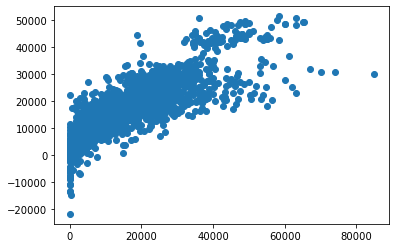

In [11]:

plt.plot(y_train, predictions_train, 'o')
    

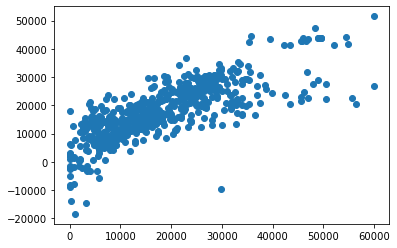

In [12]:

plt.plot(y_test, predictions_test, 'o')


# Model Fit - RF (should have used GBM since 1-hot encoding generates many features)

### In principle we should select hyperparameters through N-fold cross-validated hyperparameter optimization. I did not understand whether this was required in the excercise.

In [13]:

rf = RandomForestRegressor(random_state = seed_int,
                           n_estimators=5, criterion='mse', max_depth=20, min_samples_split=10, max_features=6, min_weight_fraction_leaf=0.0001, max_leaf_nodes=1000).fit(X_train, y_train)


## As expected, RF (slightly) overfits on train data (train_mse < test_mse). Remark: RF performs better than LM on test data on this seed (50M vs 53M).

In [14]:

predictions_train, predictions_test = perform_diagnostics(rf, X_train, X_test, y_train, y_test)


INFO:root:Train vs Test - Average target variable: 18919.045357524014 vs 18313.792
INFO:root:Train vs Test - Average model prediction: 18792.637264381778 vs 18398.028974810404
INFO:root:Train vs Test - Model mse: 50166484.12483749 vs 55640711.60914524
INFO:root:Train vs Test - Best random model mse: 150831324.76515967 vs 134658694.52076942


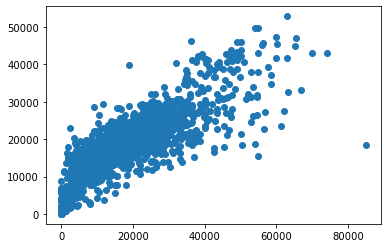

In [15]:

plt.plot(y_train, predictions_train, 'o')


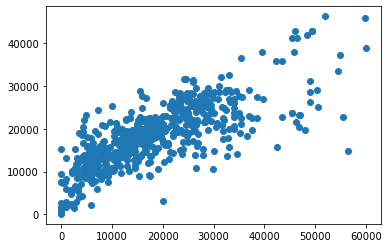

In [16]:

plt.plot(y_test, predictions_test, 'o')
